In [84]:
import pandas as pd

In [85]:
df_raw = pd.read_csv('data.csv')
df_raw.drop(columns=['Unnamed: 0'], inplace=True)
df = df_raw.copy()
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN
1,44.532972,R3,Breakdownstate_2,end state,44.532972,NaN,NaN
2,44.532972,R3,P1,start state,55.332385,Material_1 instance N.0,NaN
3,47.596494,R3,Breakdownstate_2,start state,77.596494,NaN,NaN
4,47.596494,R3,P1,start interrupt,55.332385,Material_1 instance N.0,NaN


In [86]:
import pm4py
import os
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"

In [87]:
df['DateTime'] = pd.to_datetime(df['Time'], unit='m')
df['Material_type'] = df['Material'].str[:10]
df['Combined_activity'] = df['State'] + ' ' + df['Activity']

In [88]:
df_for_pm4py = df.loc[df['Material'].notnull()]
df_for_pm4py = df_for_pm4py.rename(columns={'Material_type': 'Material:Material_type'})
df_for_pm4py = df_for_pm4py.loc[df_for_pm4py['Material:Material_type'] == 'Material_1']
df_for_pm4py = pm4py.format_dataframe(df_for_pm4py, case_id='Material', activity_key='Combined_activity', timestamp_key='DateTime')
log = pm4py.convert_to_event_log(df_for_pm4py)

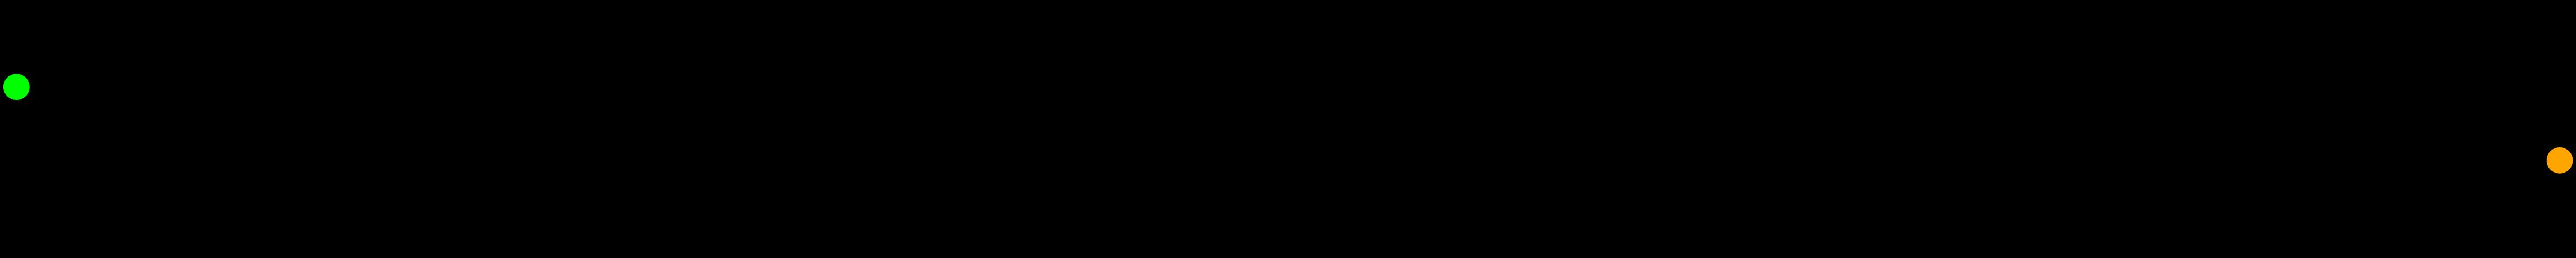

In [89]:
process_tree = pm4py.discover_process_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model, format = "jpeg")

In [90]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
# pm4py.view_petri_net(net, initial_marking, final_marking)


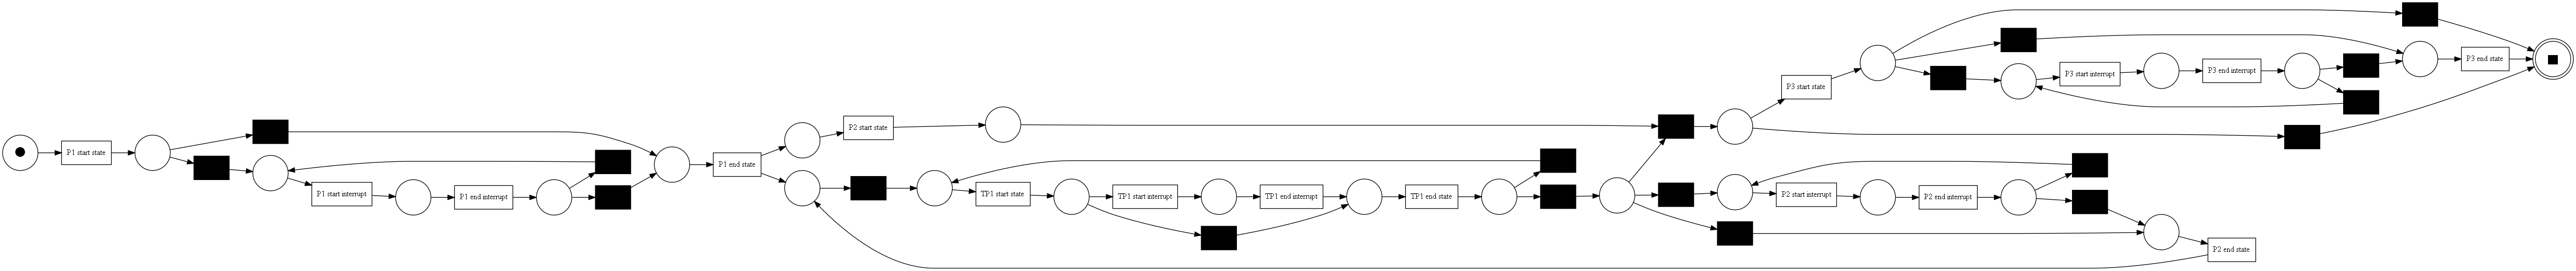

In [91]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [92]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=log)
pn_visualizer.save(gviz, "inductive_frequency.png")
# gviz.view()

replaying log with TBR, completed variants :: 100%|██████████| 57/57 [00:00<00:00, 355.27it/s]


In [93]:
# pm4py.discover_directly_follows_graph(log)

In [94]:
df = df_raw.copy()
df['Material_type'] = df['Material'].str[:10]
df.loc[df['State'].str.contains('P'), 'State_type'] = 'Process State'
df.loc[df['State'].str.contains('Breakdown'), 'State_type'] = 'Breakdown State'

In [95]:
df_process_lengths = pd.DataFrame({'Material_type': ['Material_1', 'Material_2', 'Material_3', 'Material_3'], 'length': [3, 4, 2, 3]})
df_process_lengths

,Material_type,length
0,Material_1,3
1,Material_2,4
2,Material_3,2
3,Material_3,3


In [96]:
starts = df.loc[(df['Activity'] == "end state") & (df['State'].isin(['P1', 'P2', 'P3', 'P4']))].groupby(by='Material')['Activity'].count()
starts.name = "process_starts"
ends = df.loc[(df['Activity'] == "end state") & (df['State'].isin(['P1', 'P2', 'P3', 'P4']))].groupby(by='Material')['Activity'].count()
ends.name = "process_ends"
df_finished_material = pd.merge(df[['Material_type', 'Material']].drop_duplicates(), starts.to_frame().reset_index())
df_finished_material = pd.merge(df_finished_material, ends.to_frame().reset_index())
df_finished_material = pd.merge(df_finished_material, df_process_lengths)
df_finished_material['has_finished'] = (df_finished_material['process_starts'] == df_finished_material['length']) &  (df_finished_material['process_ends'] == df_finished_material['length'])
df_finished_material = df_finished_material.loc[df_finished_material['has_finished']]
df_finished_material

,Material_type,Material,process_starts,process_ends,length,has_finished
0,Material_1,Material_1 instance N.0,3,3,3,True
1,Material_1,Material_1 instance N.6,3,3,3,True
2,Material_1,Material_1 instance N.13,3,3,3,True
3,Material_1,Material_1 instance N.18,3,3,3,True
4,Material_1,Material_1 instance N.15,3,3,3,True
...,...,...,...,...,...,...
3659,Material_3,Material_3 instance N.2729,2,2,2,True
3661,Material_3,Material_3 instance N.2733,2,2,2,True
3663,Material_3,Material_3 instance N.2734,2,2,2,True
3666,Material_3,Material_3 instance N.2732,3,3,3,True


In [97]:
df_only_finished = df.loc[df['Material'].isin(df_finished_material['Material'])].copy()
df_only_finished['DateTime'] = pd.to_datetime(df_only_finished['Time'], unit='m')
df_only_finished['Material_type'] = df_only_finished['Material'].str[:10]
df_only_finished['Combined_activity'] = df_only_finished['State'] + ' ' + df_only_finished['Activity']

In [98]:
df_only_finished.loc[(df_only_finished['Material_type'] == 'Material_3') & (df['Activity'] == "end state") & (df['State'].isin(['P1', 'P2', 'P3', 'P4']))].groupby(by='Material')['State'].apply(tuple).value_counts()

(P1, P1)        477
(P2, P3, P1)    250
(P3, P2, P1)    193
Name: State, dtype: int64

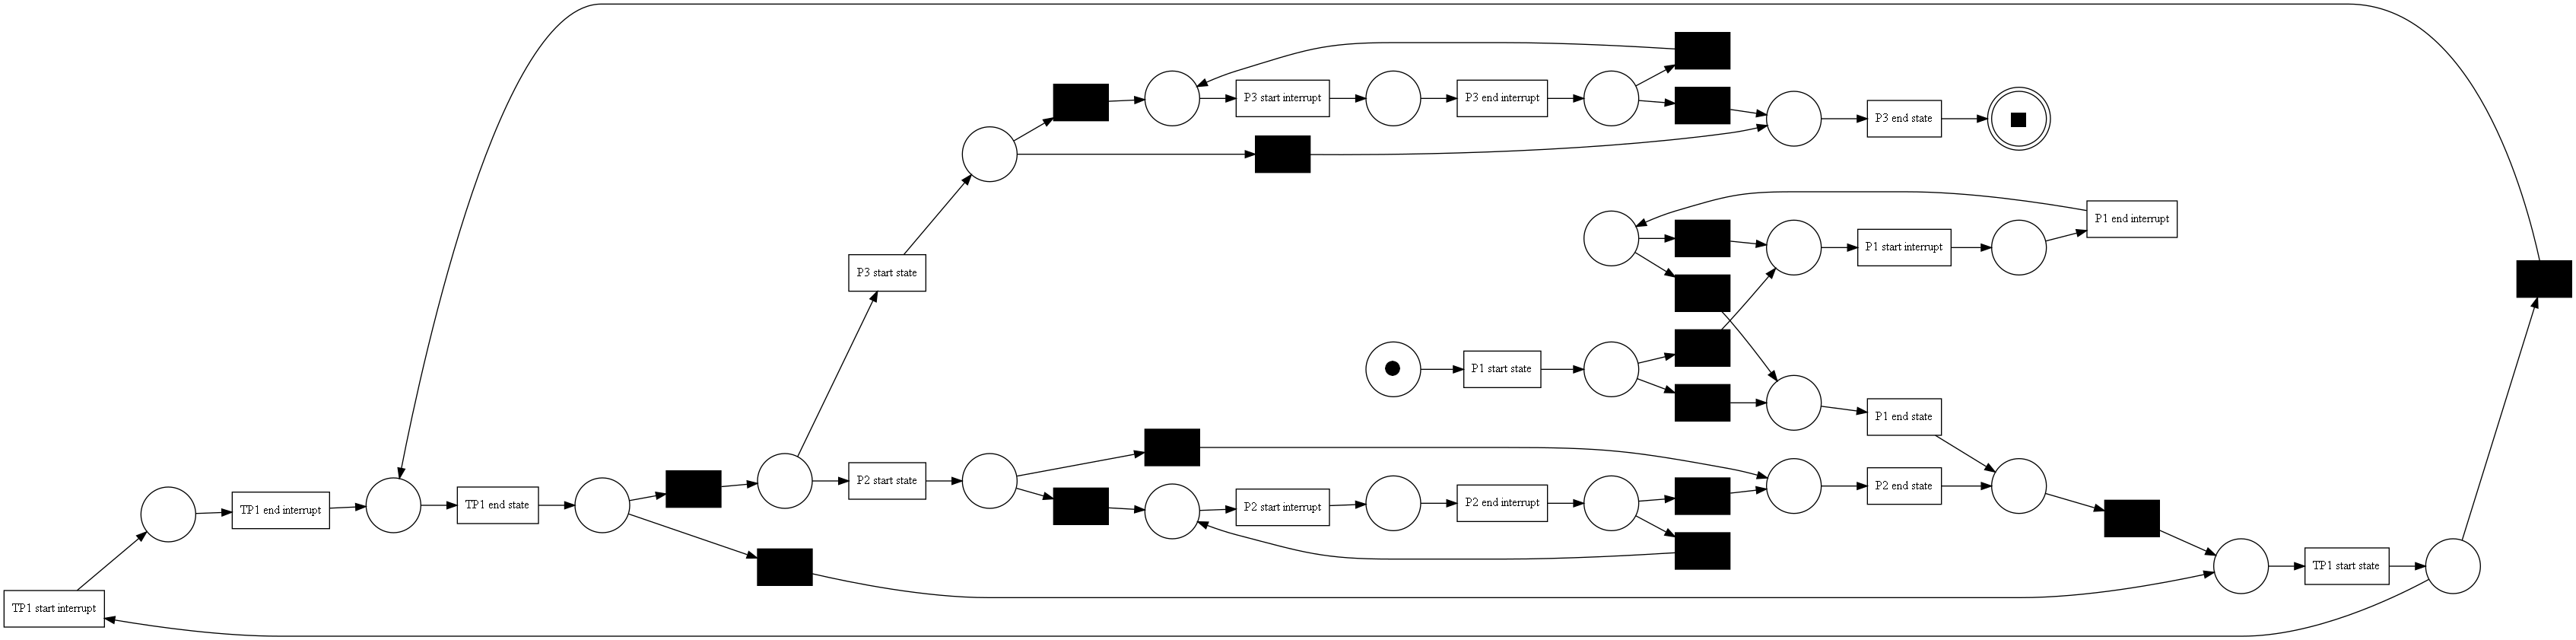

In [99]:
df_for_pm4py = df_only_finished.loc[df_only_finished['Material'].notnull()]
df_for_pm4py = df_for_pm4py.rename(columns={'Material_type': 'Material:Material_type'})
df_for_pm4py = df_for_pm4py.loc[df_for_pm4py['Material:Material_type'] == 'Material_1']
df_for_pm4py = pm4py.format_dataframe(df_for_pm4py, case_id='Material', activity_key='Combined_activity', timestamp_key='DateTime')
log = pm4py.convert_to_event_log(df_for_pm4py)
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.view_petri_net(net, initial_marking, final_marking)

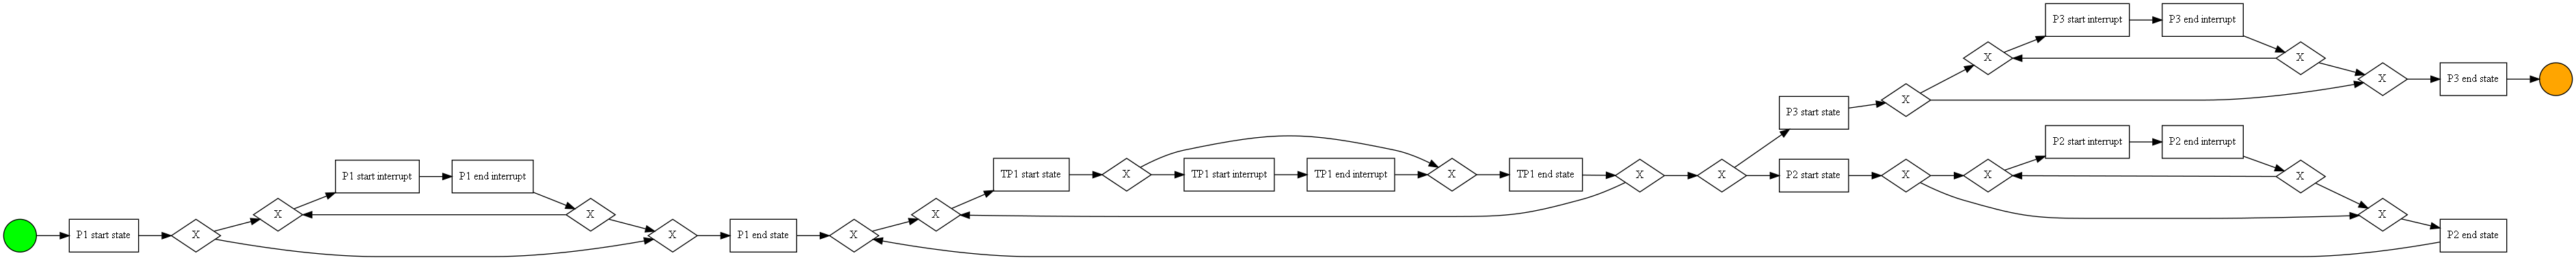

In [100]:
process_tree = pm4py.discover_process_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model, format = "png")

In [101]:
min = df.groupby(by='Material')['Time'].min()
min.name = "Start_time"
max = df.groupby(by='Material')['Time'].max()
max.name = "End_time"
tp = max - min
tp.name = "Throughput_time"

In [102]:
df_tp = pd.merge(df[['Material_type', 'Material']].drop_duplicates(), tp.to_frame().reset_index())
df_tp = pd.merge(df_tp, min.to_frame().reset_index())

In [103]:
import plotly.figure_factory as ff
import numpy as np

# Group data together
# hist_data = [x1, x2, x3, x4]

grouped = df_tp.groupby(by='Material_type')['Throughput_time'].apply(list)

values = grouped.values

group_labels = grouped.index

# Create distplot with custom bin_size
fig = ff.create_distplot(values, group_labels, bin_size=.2)
fig.show()

In [104]:
import plotly.express as px

fig = px.scatter(df_tp, x="Start_time", y="Throughput_time", color="Material_type")

fig.show()

In [105]:
df_unique = df[['State_type', 'Activity']].drop_duplicates().sort_values(by=['State_type', 'Activity'])
# df_unique['State_sorting_Index'] = [4, 3, 5, 6, 2, 1]
# df_unique['State_sorting_Index'] = [5, 4, 6, 1, 3, 2]
df_unique['State_sorting_Index'] = [1, 6, 2, 3, 5, 4]

df_unique.sort_values(by='State_sorting_Index', inplace=True)
df_unique

,State_type,Activity,State_sorting_Index
1,Breakdown State,end state,1
10,Process State,end interrupt,2
11,Process State,end state,3
2,Process State,start state,4
4,Process State,start interrupt,5
0,Breakdown State,start state,6


In [106]:
df = pd.merge(df, df_unique)
df = df.sort_values(by=['Time', 'Resource', 'State_sorting_Index'])
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6
1487,44.532972,R3,Breakdownstate_2,end state,44.532972,NaN,NaN,NaN,Breakdown State,1
2973,44.532972,R3,P1,start state,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,4
21924,47.596494,R3,P1,start interrupt,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,5
1,47.596494,R3,Breakdownstate_2,start state,77.596494,NaN,NaN,NaN,Breakdown State,6


In [107]:
positive_condition = (df['State_type'] == 'Process State') & (df['Activity'] == 'start state')
negative_condition = (df['State_type'] == 'Process State') & (df['Activity'] == 'end state')

df['Increment'] = 0
df.loc[positive_condition, 'Increment'] = 1
df.loc[negative_condition, 'Increment'] = -1

df['Used_Capacity'] = df.groupby(by='Resource')['Increment'].cumsum()
df.head(20)

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0
1487,44.532972,R3,Breakdownstate_2,end state,44.532972,NaN,NaN,NaN,Breakdown State,1,0,0
2973,44.532972,R3,P1,start state,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1
21924,47.596494,R3,P1,start interrupt,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,5,0,1
1,47.596494,R3,Breakdownstate_2,start state,77.596494,NaN,NaN,NaN,Breakdown State,6,0,1
2,51.789581,R4,Breakdownstate_1,start state,81.789581,NaN,NaN,NaN,Breakdown State,6,0,0
3,54.760325,TR1,Breakdownstate_1,start state,84.760325,NaN,NaN,NaN,Breakdown State,6,0,0
2974,62.325285,R1,P1,start state,79.340912,Material_2 instance N.2,NaN,Material_2,Process State,4,1,1
2975,66.958927,R2,P3,start state,88.464380,Material_3 instance N.3,NaN,Material_3,Process State,4,1,1
1488,77.596494,R3,Breakdownstate_2,end state,77.596494,NaN,NaN,NaN,Breakdown State,1,0,1


In [108]:
df.groupby('Resource')['Used_Capacity'].max()

Resource
R1     2
R2     1
R3     2
R4     2
TR1    1
TR2    1
Name: Used_Capacity, dtype: int64

In [109]:
import plotly.express as px

fig = px.scatter(df, x="Time", y="Used_Capacity", color="Resource")

# fig.show()

In [110]:
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0
1487,44.532972,R3,Breakdownstate_2,end state,44.532972,NaN,NaN,NaN,Breakdown State,1,0,0
2973,44.532972,R3,P1,start state,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1
21924,47.596494,R3,P1,start interrupt,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,5,0,1
1,47.596494,R3,Breakdownstate_2,start state,77.596494,NaN,NaN,NaN,Breakdown State,6,0,1


In [111]:
df['next_State_sorting_Index'] = df.groupby(by='Resource')['State_sorting_Index'].shift(-1)
df['next_Time'] = df.groupby('Resource')['Time'].shift(-1)
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity,next_State_sorting_Index,next_Time
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0,1.0,44.532972
1487,44.532972,R3,Breakdownstate_2,end state,44.532972,NaN,NaN,NaN,Breakdown State,1,0,0,4.0,44.532972
2973,44.532972,R3,P1,start state,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1,5.0,47.596494
21924,47.596494,R3,P1,start interrupt,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,5,0,1,6.0,47.596494
1,47.596494,R3,Breakdownstate_2,start state,77.596494,NaN,NaN,NaN,Breakdown State,6,0,1,1.0,77.596494


In [112]:
df[['State_sorting_Index', 'next_State_sorting_Index']].value_counts()

State_sorting_Index  next_State_sorting_Index
3                    4.0                         17113
4                    3.0                         17093
6                    1.0                          1486
3                    3.0                          1173
4                    4.0                          1132
5                    6.0                           894
1                    2.0                           893
4                    5.0                           723
2                    3.0                           679
1                    4.0                           588
3                    6.0                           585
2                    2.0                           350
5                    5.0                           350
2                    4.0                           115
                     5.0                            99
3                    5.0                            72
1                    6.0                             5
dtype: int64

In [113]:
df_unique

,State_type,Activity,State_sorting_Index
1,Breakdown State,end state,1
10,Process State,end interrupt,2
11,Process State,end state,3
2,Process State,start state,4
4,Process State,start interrupt,5
0,Breakdown State,start state,6


In [114]:
STANDBY_CONDITION = (df['State_sorting_Index'] == 1) | ((df['State_sorting_Index'] == 3) & (df['Used_Capacity'] == 0))
PRODUCTIVE_CONDITION = (df['State_sorting_Index'] == 4) | (df['State_sorting_Index'] == 2) | ((df['State_sorting_Index'] == 3) & df['Used_Capacity'] != 0)
DOWN_CONDITION = (df['State_sorting_Index'] == 5) | (df['State_sorting_Index'] == 6)

df['time_increment'] = df['next_Time'] - df['Time']

df.loc[STANDBY_CONDITION, 'Time_type'] = 'SB'
df.loc[PRODUCTIVE_CONDITION, 'Time_type'] = 'PR'
df.loc[DOWN_CONDITION, 'Time_type'] = 'UD'

In [115]:
df.head()

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity,next_State_sorting_Index,next_Time,time_increment,Time_type
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0,1.0,44.532972,30.000000,UD
1487,44.532972,R3,Breakdownstate_2,end state,44.532972,NaN,NaN,NaN,Breakdown State,1,0,0,4.0,44.532972,0.000000,SB
2973,44.532972,R3,P1,start state,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1,5.0,47.596494,3.063523,PR
21924,47.596494,R3,P1,start interrupt,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,5,0,1,6.0,47.596494,0.000000,UD
1,47.596494,R3,Breakdownstate_2,start state,77.596494,NaN,NaN,NaN,Breakdown State,6,0,1,1.0,77.596494,30.000000,UD


In [116]:
# df.loc[df['Resource'] == 'R3', ['Time', 'State', 'Activity', 'State_sorting_Index', 'Used_Capacity', 'time_increment', 'Time_type']].head()

In [117]:
df_time_per_state = df.groupby(['Resource', 'Time_type'])['time_increment'].sum()
df_time_per_state = df_time_per_state.to_frame().reset_index()
df_time_per_state

,Resource,Time_type,time_increment
0,R1,PR,25184.487946
1,R1,SB,8747.405954
2,R1,UD,6000.000000
3,R2,PR,31940.331155
4,R2,SB,1691.939609
5,R2,UD,6300.000000
6,R3,PR,24366.102476
7,R3,SB,3191.969253
8,R3,UD,12420.000000
9,R4,PR,22738.835527


In [119]:
df_resource_time = df_time_per_state.groupby(by='Resource').sum().reset_index()
df_resource_time.rename(columns={'time_increment': 'resource_time'}, inplace=True)
df_time_per_state = pd.merge(df_time_per_state, df_resource_time)
# time_ratio = df_time_ratio / df_time_ratio_resource_time
df_time_per_state['percentage'] = df_time_per_state['time_increment'] / df_time_per_state['resource_time']

In [120]:
df_time_per_state

,Resource,Time_type,time_increment,resource_time,percentage
0,R1,PR,25184.487946,39931.893900,0.630686
1,R1,SB,8747.405954,39931.893900,0.219058
2,R1,UD,6000.000000,39931.893900,0.150256
3,R2,PR,31940.331155,39932.270764,0.799863
4,R2,SB,1691.939609,39932.270764,0.042370
5,R2,UD,6300.000000,39932.270764,0.157767
6,R3,PR,24366.102476,39978.071729,0.609487
7,R3,SB,3191.969253,39978.071729,0.079843
8,R3,UD,12420.000000,39978.071729,0.310670
9,R4,PR,22738.835527,39938.482037,0.569347


In [121]:
import plotly.express as px

fig = px.bar(df_time_per_state, x="Resource", y="time_increment", color="Time_type", color_discrete_map={'PR': 'green', 'SB': 'yellow', 'UD': 'red' })
fig.show()

In [122]:
df.head(30)

,Time,Resource,State,Activity,Expected End Time,Material,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity,next_State_sorting_Index,next_Time,time_increment,Time_type
0,14.532972,R3,Breakdownstate_2,start state,44.532972,NaN,NaN,NaN,Breakdown State,6,0,0,1.0,44.532972,30.000000,UD
1487,44.532972,R3,Breakdownstate_2,end state,44.532972,NaN,NaN,NaN,Breakdown State,1,0,0,4.0,44.532972,0.000000,SB
2973,44.532972,R3,P1,start state,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,4,1,1,5.0,47.596494,3.063523,PR
21924,47.596494,R3,P1,start interrupt,55.332385,Material_1 instance N.0,NaN,Material_1,Process State,5,0,1,6.0,47.596494,0.000000,UD
1,47.596494,R3,Breakdownstate_2,start state,77.596494,NaN,NaN,NaN,Breakdown State,6,0,1,1.0,77.596494,30.000000,UD
2,51.789581,R4,Breakdownstate_1,start state,81.789581,NaN,NaN,NaN,Breakdown State,6,0,0,1.0,81.789581,30.000000,UD
3,54.760325,TR1,Breakdownstate_1,start state,84.760325,NaN,NaN,NaN,Breakdown State,6,0,0,1.0,84.760325,30.000000,UD
2974,62.325285,R1,P1,start state,79.340912,Material_2 instance N.2,NaN,Material_2,Process State,4,1,1,3.0,79.340912,17.015627,PR
2975,66.958927,R2,P3,start state,88.464380,Material_3 instance N.3,NaN,Material_3,Process State,4,1,1,3.0,88.464380,21.505452,PR
1488,77.596494,R3,Breakdownstate_2,end state,77.596494,NaN,NaN,NaN,Breakdown State,1,0,1,2.0,77.596494,0.000000,SB


In [123]:
df['Process_number_increment'] = 0
PROCESS_END_CONDITION = (df['State_type'] == 'Process State') & (df['Activity'] == 'end state') & (~df['State'].str.contains('T'))
df.loc[PROCESS_END_CONDITION, 'Process_number_increment'] = 1
df['Process_number'] = df.groupby(by='Material')['Process_number_increment'].cumsum()

df = pd.merge(df, df_process_lengths)
df['WIP_Increment'] = 0
df.loc[df['Process_number'] == df['length'], 'WIP_Increment'] = -1

In [124]:
df_first_appearance = df.groupby(by='Material').first()['Time'].reset_index()
df_first_appearance['Start_increment'] = 1
df = pd.merge(df, df_first_appearance, how='left')
df.loc[df['Start_increment'] == 1, 'WIP_Increment'] = df['Start_increment']
df['WIP'] = df['WIP_Increment'].cumsum()

In [125]:
import plotly.express as px

fig = px.scatter(df, x="Time", y="WIP")

fig.show()